In [1]:
import pandas as pd
import torch
import torch.nn as nn
import tensorflow
import tqdm
import numpy as np
import tiktoken

from torch.utils.data import Dataset, DataLoader
from gpt_download3 import load_gpt

2024-12-12 11:18:43.180674: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 11:18:43.302727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 11:18:43.302818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 11:18:43.322444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 11:18:43.366391: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# import urllib.request
# import ssl
# import zipfile
# import os
# from pathlib import Path

# url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
# zip_path = "sms_spam_collection.zip"
# extracted_path = "sms_spam_collection"
# data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

# def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
#     if data_file_path.exists():
#         print(f"{data_file_path} already exists. Skipping download and extraction.")
#         return

#     # Create an unverified SSL context
#     ssl_context = ssl._create_unverified_context()

#     # Downloading the file
#     with urllib.request.urlopen(url, context=ssl_context) as response:
#         with open(zip_path, "wb") as out_file:
#             out_file.write(response.read())

#     # Unzipping the file
#     with zipfile.ZipFile(zip_path, "r") as zip_ref:
#         zip_ref.extractall(extracted_path)

#     # Add .tsv file extension
#     original_file_path = Path(extracted_path) / "SMSSpamCollection"
#     os.rename(original_file_path, data_file_path)
#     print(f"File downloaded and saved as {data_file_path}")

# download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


In [3]:
df = pd.read_csv("sms_spam_collection/SMSSpamCollection.tsv", sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
df["Label"].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    return pd.concat([ham_subset, df[df["Label"] == "spam"]])

In [6]:
balanced_df = create_balanced_dataset(df)
balanced_df["Label"].value_counts()

Label
ham     747
spam    747
Name: count, dtype: int64

In [7]:
# Similar to tokenization

balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [8]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [9]:
def random_split(df, train_frac, valid_frac):
    # shuffle the dataframe
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    train_end = int(len(df)*train_frac)
    valid_end = train_end + int(len(df)*valid_frac)
    
    train_df = df[:train_end]
    valid_df = df[train_end:valid_end]
    test_df = df[valid_end:]

    return train_df, valid_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [10]:
a = len(train_df)
b = len(validation_df)
c = len(test_df)

print(a)
print(b)
print(c)
print("Summ of all split: ", a+b+c)

1045
149
300
Summ of all split:  1494


In [11]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [12]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]


        if max_length is None:
            self.max_length = self._longest_encoded_text()
        else:
            self.max_length = max_length
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]
        
        self.encoded_texts = [
            encoded_text + [pad_token_id]*(self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_text(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            if len(encoded_text) > max_length:
                max_length = len(encoded_text)
        return max_length

In [13]:
tokenizer = tiktoken.get_encoding("gpt2")

In [14]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    tokenizer=tokenizer,
    max_length=None,
    pad_token_id=50256
)
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

print(train_dataset.max_length)
print(val_dataset.max_length)
print(test_dataset.max_length)

120
120
120


In [15]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

valid_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [16]:
print("Train loader one batch shape:")
for input_batch, target_batch in train_loader:
    pass

print(input_batch.shape)
print(target_batch.shape)

print(f"Like this there are: {len(train_loader)} batches in total inside train loader")
print(f"Like this there are: {len(valid_loader)} batches in total inside valid loader")
print(f"Like this there are: {len(test_loader)} batches in total inside test loader")

Train loader one batch shape:
torch.Size([8, 120])
torch.Size([8])
Like this there are: 130 batches in total inside train loader
Like this there are: 18 batches in total inside valid loader
Like this there are: 37 batches in total inside test loader


In [17]:
settings, params = load_gpt(models_dir="/home/abhinav/Documents/Work/2 Hobby_projects/Models/gpt2", model_size="124M")

In [18]:
print(settings)
print(params.keys())

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [19]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 128,
    "emb_dim" : 708,
    "n_heads" : 12,
    "n_layers" : 11,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}
batch_size = 3

In [20]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})


In [21]:
print(NEW_CONFIG)

{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': True}


In [22]:
class LayerNorm(nn.Module):

    def __init__(self, emb_dim):
        super().__init__()

        self.eps = 1e-05
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):

        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / (torch.sqrt(variance + self.eps))

        return self.scale * norm_x + self.shift
    
class GELU(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return  0.5 * x * ( 1 + torch.tanh( torch.sqrt(  torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3)  ) ))

class FeedForward(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)
    
class MultiHeadAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)

        self.dropout = nn.Dropout(dropout)

        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, x):

        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

In [23]:
class TransformerBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        self.ff = FeedForward(cfg=cfg)
    
    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [25]:
class GPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[ TransformerBlock(cfg) for _ in range(cfg["n_layers"]) ]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])

        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.token_emb(in_idx).to(device=device)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [26]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [27]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Left shape: {left.shape}, Right shape: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [28]:
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [29]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [30]:
def text_to_token_ids(text, tokenizer):
    tokens = tokenizer.encode(text, allowed_special={"<|endoftoken|>"})
    tokens = torch.tensor(tokens).unsqueeze(0)
    return tokens

def token_ids_to_text(idx, tokenizer):
    text = idx.squeeze(0)
    return tokenizer.decode(text.tolist())

In [31]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [32]:
text1 = "Every effort moves you"
text2 = "Is the following text spam? 'You are a winner, you have been specially selected to recieve 1000 dollars' ? Answer it with a yes or no"

In [33]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(text1, tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn. By now there's a very small delay before you gain


In [34]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(text2, tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Is the following text spam? 'You are a winner, you have been specially selected to recieve 1000 dollars' ? Answer it with a yes or no as you were invited to use this program (and that means you want to receive more). In your own time (no matter


In [35]:
for param in gpt.parameters():
    param.requires_grad = False

In [36]:
torch.manual_seed(123)

num_classes = 2

gpt.out_head = nn.Linear(in_features=NEW_CONFIG["emb_dim"], out_features=num_classes)

In [37]:
for param in gpt.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in gpt.final_norm.parameters():
    param.requires_grad = True

In [38]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [39]:
# with torch.no_grad():
#     outputs = gpt(inputs)

# print("Outputs:\n", outputs)
# print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)#
# print("Last output: ", outputs[:, -1 ,:])

In [40]:
def calc_accuracy_loader(dataloader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    
    if num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    
    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device=device), target_batch.to(device=device)
            with torch.no_grad():
                logits = model(input_batch)[:, -1 ,:]
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples
            

In [41]:
gpt.to(device=device)

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [42]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, gpt, device, num_batches=10)
val_accuracy = calc_accuracy_loader(valid_loader, gpt, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 53.75%
Test accuracy: 50.00%


In [43]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device=device), target_batch.to(device=device)
    logits = model(input_batch)[:, -1 ,:]
    # print("Input to model:")
    # for k, i in enumerate(input_batch):
    #     print("Looking at ", k, " example\n")
    #     print("Its target value is: ", target_batch[k])
    #     print(token_ids_to_text(i, tokenizer=tokenizer))
    # print("logits:")
    # print(logits.shape)
    # print(logits)
    # print("target_batch")
    # print(target_batch.shape)
    # print(target_batch)
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [44]:
def calc_loss_loader(dataloader, model, device, num_batches=None):
    total_loss = 0
    if len(dataloader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch=input_batch, target_batch=target_batch, model=model, device=device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [45]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, gpt, device)
    val_loss = calc_loss_loader(valid_loader, gpt, device)
    test_loss = calc_loss_loader(test_loader, gpt, device)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.605
Validation loss: 2.474
Test loss: 2.548


In [46]:
# a = torch.tensor([[0., 1.], [0., 1.]])
# a = torch.argmax(a, dim=-1)
# print(a.shape)
# b = torch.tensor([[0.], [0.]])

# print(torch.nn.functional.cross_entropy(a, b))

In [47]:
def evaluate_model(model, train_loader, valid_loader, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(valid_loader, model, device, eval_iter)
    model.train()
    return train_loss, val_loss

In [48]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        print("Epoch: ", epoch)
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"(Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [49]:
import time

In [50]:
start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-4, weight_decay=0.1)

num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt, train_loader,
    valid_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq=50, 
    eval_iter=5
    )

end_time = time.time()

execution_time = (end_time - start_time) / 60

print("Training completed")
print(f"Total training time: {execution_time:.2f}")

Epoch:  0
(Step 000000): Train loss 0.780, Val loss 0.915
(Step 000050): Train loss 0.553, Val loss 0.564
(Step 000100): Train loss 0.097, Val loss 0.378
Training accuracy: 87.50% | Validation accuracy: 100.00%
Epoch:  1
(Step 000150): Train loss 0.026, Val loss 0.032
(Step 000200): Train loss 0.021, Val loss 0.131
(Step 000250): Train loss 0.022, Val loss 0.033
Training accuracy: 97.50% | Validation accuracy: 100.00%
Epoch:  2
(Step 000300): Train loss 0.020, Val loss 0.040
(Step 000350): Train loss 0.101, Val loss 0.046
Training accuracy: 97.50% | Validation accuracy: 100.00%
Epoch:  3
(Step 000400): Train loss 0.202, Val loss 0.000
(Step 000450): Train loss 0.070, Val loss 0.188
(Step 000500): Train loss 0.064, Val loss 0.100
Training accuracy: 100.00% | Validation accuracy: 97.50%
Epoch:  4
(Step 000550): Train loss 0.107, Val loss 0.012
(Step 000600): Train loss 0.003, Val loss 0.003
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed
Total training time: 1

In [51]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

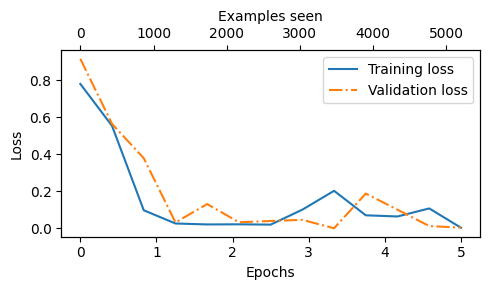

In [52]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [53]:
train_accuracy = calc_accuracy_loader(train_loader, gpt, device)
val_accuracy = calc_accuracy_loader(valid_loader, gpt, device)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.85%
Validation accuracy: 99.31%
Test accuracy: 97.30%


In [54]:
def classify_review(text, model, device, tokenizer, max_length=None, pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    if max_length > supported_context_length:
        max_length = supported_context_length
    input_ids = input_ids[:min(max_length, supported_context_length)]
    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1 ,:]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "Spam" if predicted_label == 1 else "Not spam"

In [55]:
texts = [
    (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
    ),
    (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"),
    ("Hey winner champ, we are gonna miss you"),
    ("Won 1000 dollars, please give otp"),
    ("You are selected as the winner")
]

for i in texts:
    print(classify_review(
        text=i,
        model=gpt,
        device=device,
        tokenizer=tokenizer,
        max_length=train_dataset.max_length,
    ))

Spam
Not spam
Not spam
Not spam
Not spam


In [56]:
import tensorflow as tf

In [57]:
print(tf.__version__)

2.15.0
